In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Wed Dec  4 07:38:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [9]:

def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

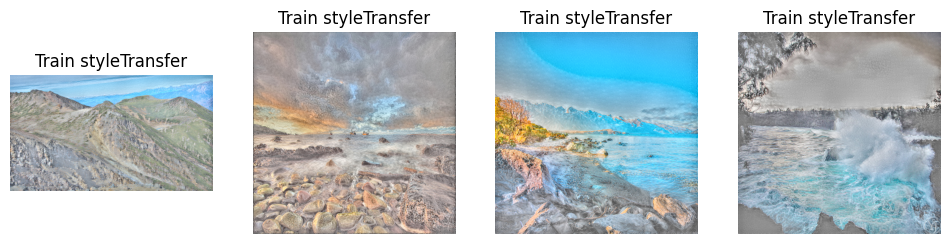

Train styleTransfer 총 이미지 수: 889


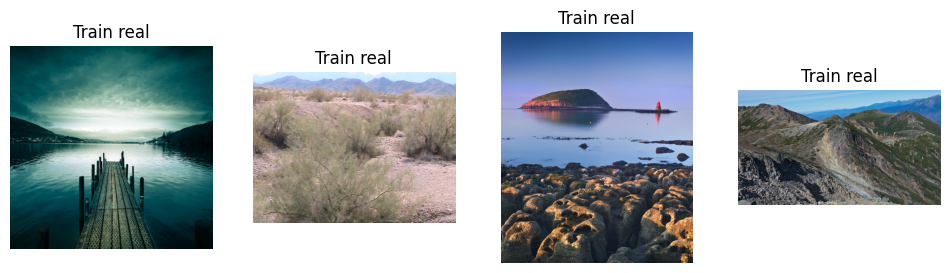

Train real 총 이미지 수: 889


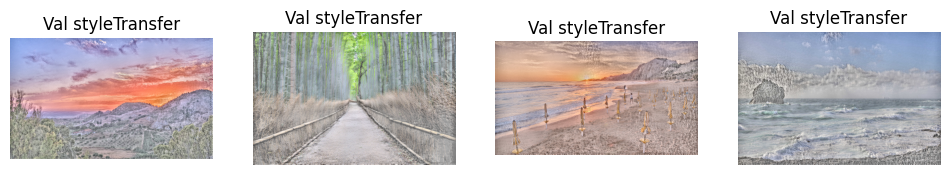

Val styleTransfer 총 이미지 수: 109


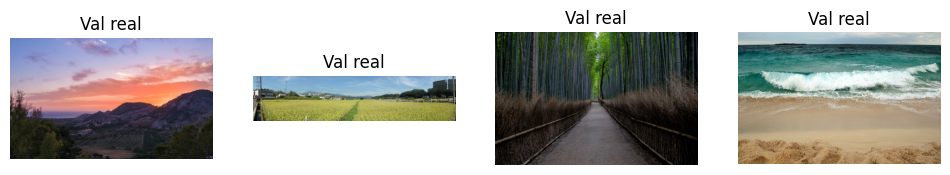

Val real 총 이미지 수: 109


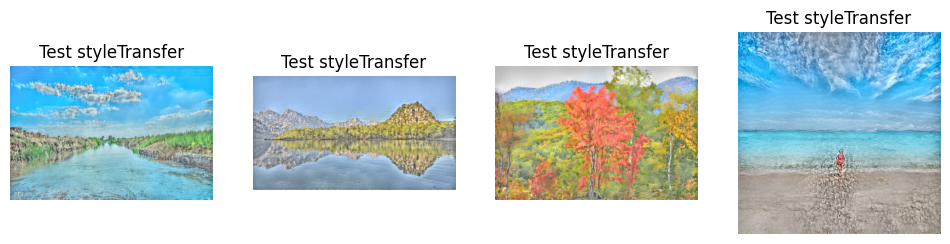

Test styleTransfer 총 이미지 수: 32


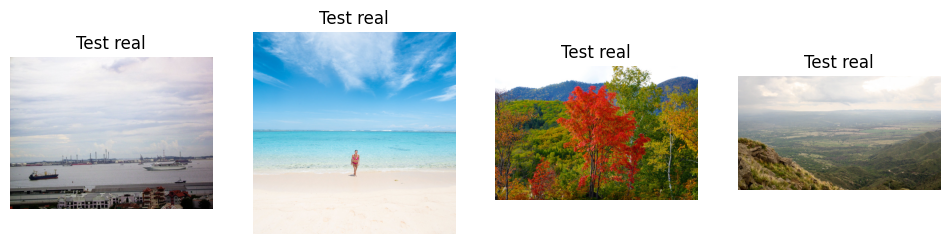

Test real 총 이미지 수: 32


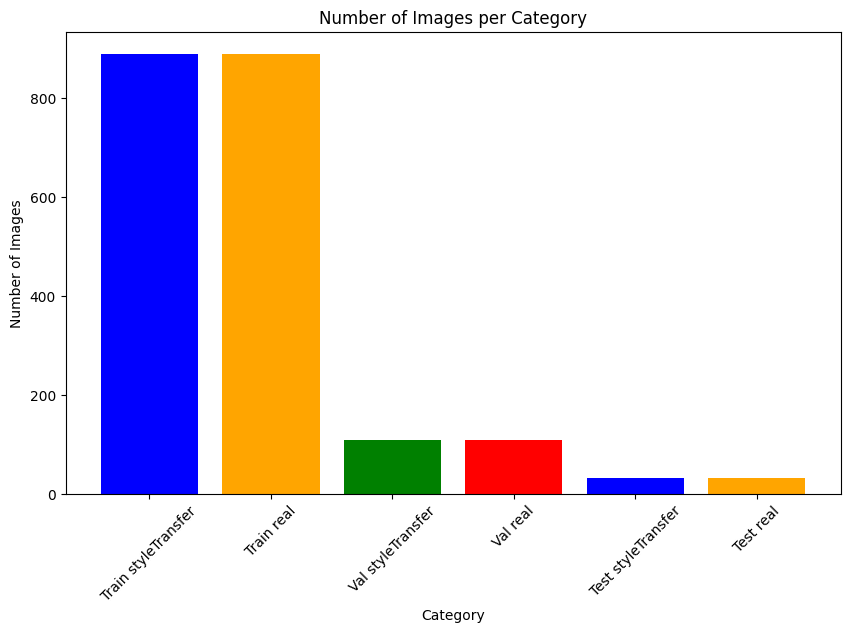

In [11]:

categories = ['Train styleTransfer', 'Train real', 'Val styleTransfer', 'Val real', 'Test styleTransfer', 'Test real']

for category in categories:
    image_paths = glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/8/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/8/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [12]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [13]:
import albumentations as A

In [14]:
import albumentations as A
import numpy as np
import cv2

class ImgAugTransform:
    def __init__(self):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=20, border_mode=cv2.BORDER_REFLECT),
            A.OneOf([
                A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05),
                A.GridDistortion(num_steps=5, distort_limit=0.3),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50)
            ], p=0.5),
            A.RandomBrightnessContrast(contrast_limit=0.75, p=0.5),
        ])

    def __call__(self, img):
        return self.aug(image=np.array(img))['image']


In [15]:
# from imgaug import augmenters as iaa
# import imgaug as ia

# # imgaug를 사용한 커스텀 데이터셋 정의
# class ImgAugTransform:
#     def __init__(self):
#         self.aug = iaa.Sequential([
#             iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
#             iaa.Flipud(0.2),  # 20% 확률로 상하 반전
#             iaa.Affine(rotate=(-20, 20), mode='symmetric'),  # -20도에서 20도 사이로 회전
#             iaa.LinearContrast((0.75, 1.5)),  # 대비 조절
#             iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25),  # 탄성 변형
#         ])

#     def __call__(self, img):
#         img = np.array(img)
#         return self.aug.augment_image(img)

In [16]:

class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug 

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        reduced_samples = []
        for target, paths in class_samples.items():
            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])
            else:
                reduced_samples.extend([(path, target) for path in paths])


        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [17]:

from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [18]:

train_dataset = CustomDataset('/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/8/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/8/val', imgaug=None, transform=pytorch_transforms, sample_per_class=20)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

<ipython-input-14-5ff15614091f>:14: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50)


In [19]:

def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean 
    img = np.clip(img, 0, 1)  
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    for i, label in enumerate(labels[:8]): 
        class_name = idx_to_class[label.item()]
        x = (i % 4) * (img.shape[1] // 4) + 100 
        y = (i // 4) * (img.shape[0] // 2) + 10 
        plt.text(x, y, f'{label.item()}, {class_name}', color='white', fontsize=14)

    plt.show()

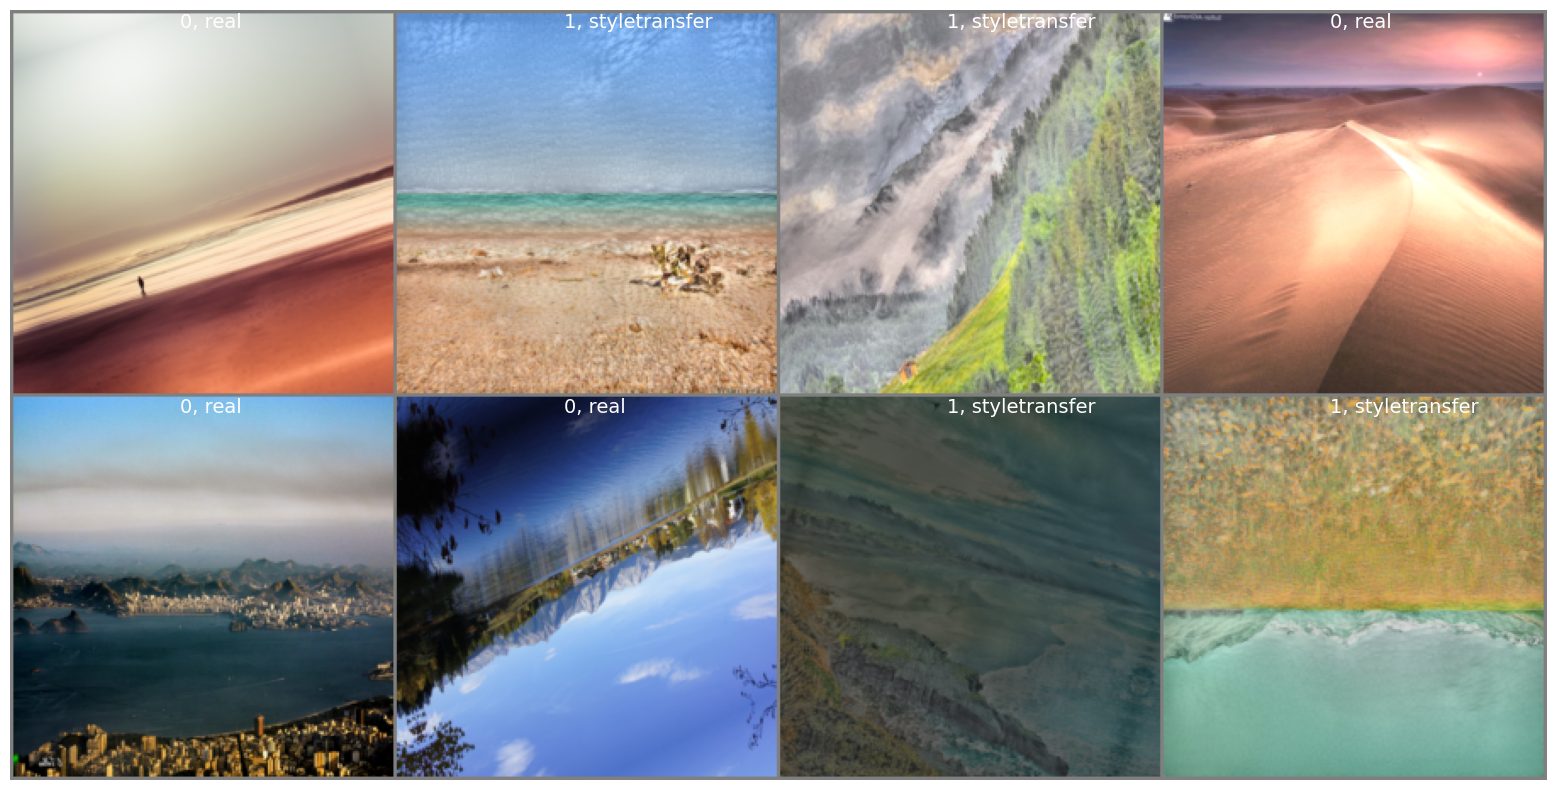

In [20]:

dataiter = iter(train_loader)
images, label = next(dataiter)

class_to_idx = train_loader.dataset.class_to_idx  

imshow(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

In [21]:

densenet = models.densenet169(pretrained=True)

for param in densenet.parameters():
    param.requires_grad = False

print(densenet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 118MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
densenet.classifier = nn.Linear(1664, 1, bias=True)
densenet.classifier.requires_grad = True

densenet = densenet.to(device)

In [23]:

criterion = nn.BCEWithLogitsLoss()

In [24]:
def validate_model(net, val_loader, criterion):
    net.eval()  
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1) 
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [25]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.0003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [26]:
train_losses_densenet, val_losses_densenet, val_accuracies_densenet = train_model('RAdam', densenet, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 56/56 [11:35<00:00, 12.41s/it]


[RAdam] Epoch 1, Train Loss: 0.689086, Val Loss: 0.673407, Validation Accuracy: 65.00%


Epoch 2/20: 100%|██████████| 56/56 [02:14<00:00,  2.41s/it]


[RAdam] Epoch 2, Train Loss: 0.648428, Val Loss: 0.604825, Validation Accuracy: 75.00%


Epoch 3/20: 100%|██████████| 56/56 [02:12<00:00,  2.36s/it]


[RAdam] Epoch 3, Train Loss: 0.596580, Val Loss: 0.531894, Validation Accuracy: 95.00%


Epoch 4/20: 100%|██████████| 56/56 [02:10<00:00,  2.33s/it]


[RAdam] Epoch 4, Train Loss: 0.540415, Val Loss: 0.485348, Validation Accuracy: 95.00%


Epoch 5/20: 100%|██████████| 56/56 [02:09<00:00,  2.31s/it]


[RAdam] Epoch 5, Train Loss: 0.490759, Val Loss: 0.414814, Validation Accuracy: 100.00%


Epoch 6/20: 100%|██████████| 56/56 [02:11<00:00,  2.34s/it]


[RAdam] Epoch 6, Train Loss: 0.445036, Val Loss: 0.385763, Validation Accuracy: 97.50%


Epoch 7/20: 100%|██████████| 56/56 [02:08<00:00,  2.30s/it]


[RAdam] Epoch 7, Train Loss: 0.396509, Val Loss: 0.330660, Validation Accuracy: 100.00%


Epoch 8/20: 100%|██████████| 56/56 [02:13<00:00,  2.39s/it]


[RAdam] Epoch 8, Train Loss: 0.361626, Val Loss: 0.302304, Validation Accuracy: 100.00%


Epoch 9/20: 100%|██████████| 56/56 [02:08<00:00,  2.30s/it]


[RAdam] Epoch 9, Train Loss: 0.343848, Val Loss: 0.267351, Validation Accuracy: 100.00%


Epoch 10/20: 100%|██████████| 56/56 [02:10<00:00,  2.33s/it]


[RAdam] Epoch 10, Train Loss: 0.319902, Val Loss: 0.239984, Validation Accuracy: 100.00%


Epoch 11/20: 100%|██████████| 56/56 [02:07<00:00,  2.27s/it]


[RAdam] Epoch 11, Train Loss: 0.297616, Val Loss: 0.216189, Validation Accuracy: 100.00%


Epoch 12/20: 100%|██████████| 56/56 [02:09<00:00,  2.30s/it]


[RAdam] Epoch 12, Train Loss: 0.270701, Val Loss: 0.196531, Validation Accuracy: 100.00%


Epoch 13/20: 100%|██████████| 56/56 [02:07<00:00,  2.28s/it]


[RAdam] Epoch 13, Train Loss: 0.249400, Val Loss: 0.174949, Validation Accuracy: 100.00%


Epoch 14/20: 100%|██████████| 56/56 [02:07<00:00,  2.27s/it]


[RAdam] Epoch 14, Train Loss: 0.235049, Val Loss: 0.194271, Validation Accuracy: 97.50%


Epoch 15/20: 100%|██████████| 56/56 [02:11<00:00,  2.35s/it]


[RAdam] Epoch 15, Train Loss: 0.218562, Val Loss: 0.163129, Validation Accuracy: 100.00%


Epoch 16/20: 100%|██████████| 56/56 [02:07<00:00,  2.28s/it]


[RAdam] Epoch 16, Train Loss: 0.210598, Val Loss: 0.146742, Validation Accuracy: 100.00%


Epoch 17/20: 100%|██████████| 56/56 [02:07<00:00,  2.28s/it]


[RAdam] Epoch 17, Train Loss: 0.199160, Val Loss: 0.151141, Validation Accuracy: 97.50%


Epoch 18/20: 100%|██████████| 56/56 [02:11<00:00,  2.34s/it]


[RAdam] Epoch 18, Train Loss: 0.204137, Val Loss: 0.149259, Validation Accuracy: 97.50%


Epoch 19/20: 100%|██████████| 56/56 [02:09<00:00,  2.31s/it]


[RAdam] Epoch 19, Train Loss: 0.187309, Val Loss: 0.132758, Validation Accuracy: 100.00%


Epoch 20/20: 100%|██████████| 56/56 [02:08<00:00,  2.30s/it]


[RAdam] Epoch 20, Train Loss: 0.167208, Val Loss: 0.127002, Validation Accuracy: 97.50%


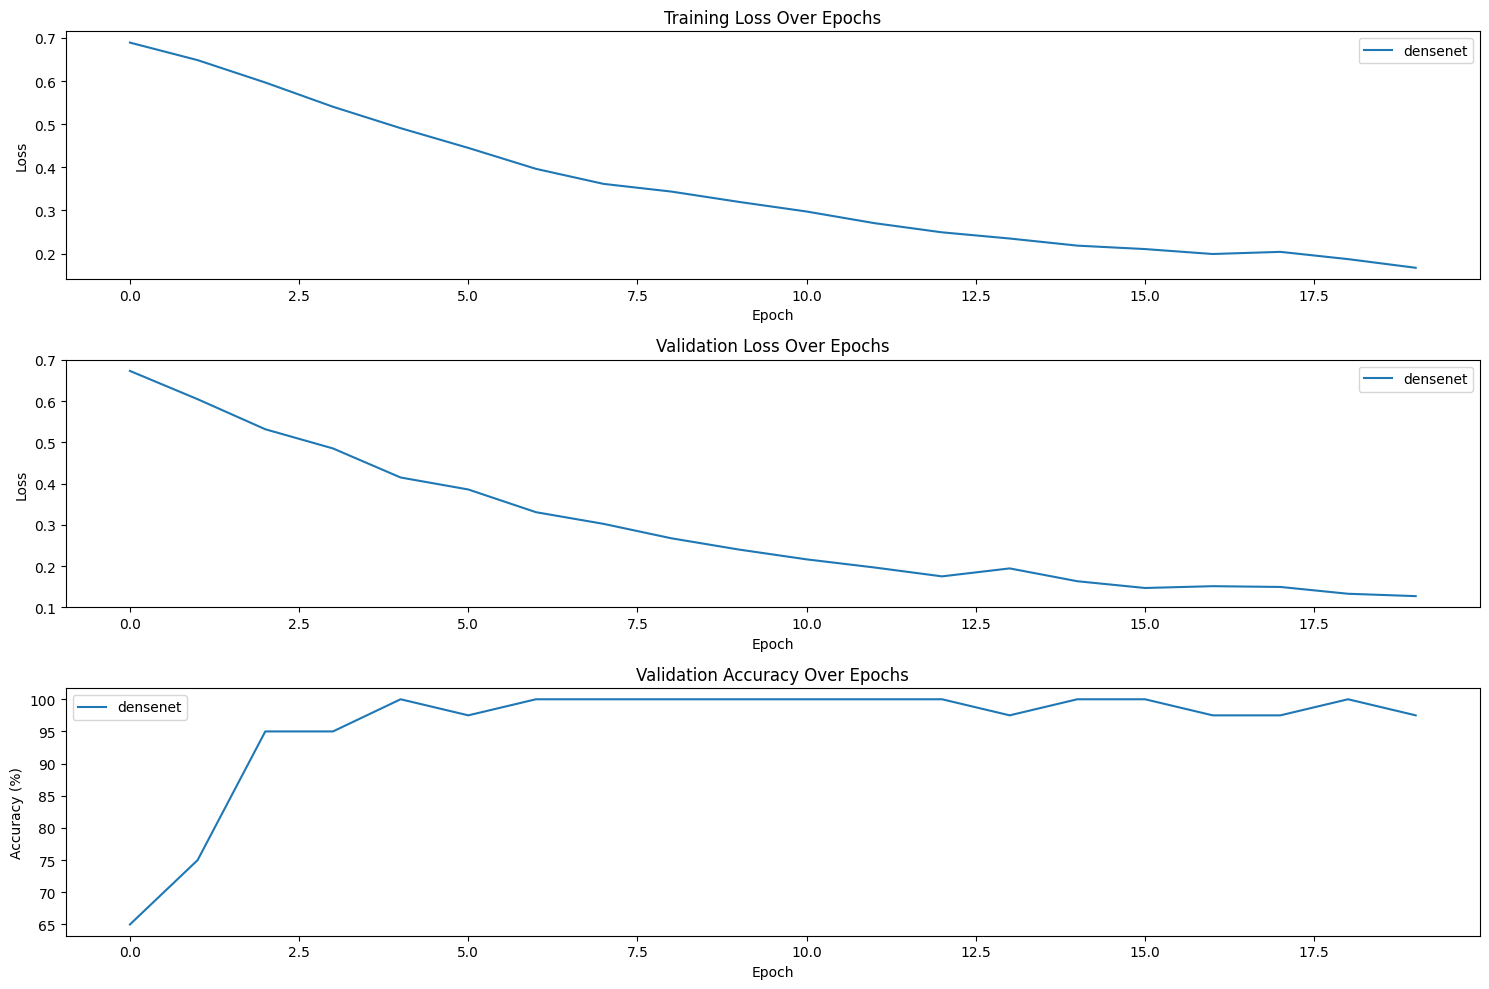

In [27]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)  
plt.plot(train_losses_densenet, label='densenet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)  
plt.plot(val_losses_densenet, label='densenet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3) 
plt.plot(val_accuracies_densenet, label='densenet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:

def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device) 

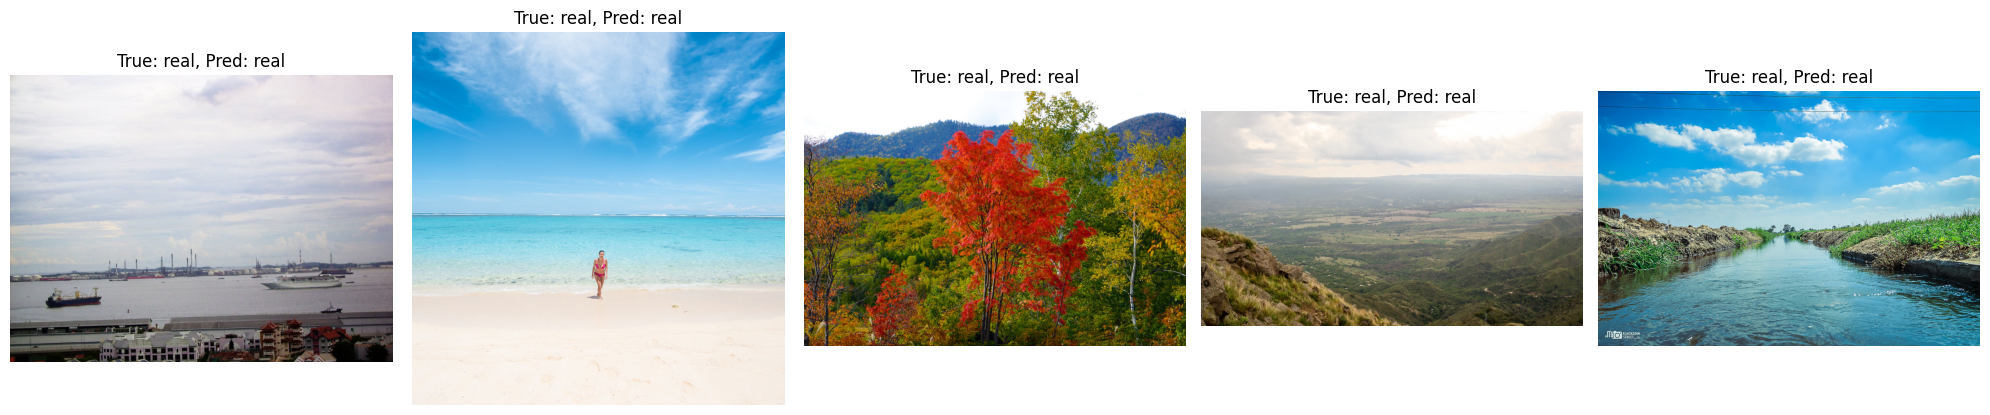

In [29]:

class_folders = {
    'styleTransfer': '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/8/test/styleTransfer',
    'real': '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/8/test/real'
}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5] 

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        densenet.eval()  
        with torch.no_grad():
            outputs = densenet(image)
            
            probs = torch.sigmoid(outputs).item()
            prediction = 'styleTransfer' if probs >= 0.5 else 'real'

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  

plt.tight_layout()
plt.show()